In [1]:
import os, sys, gzip, contextlib
import pubchempy as pcp
import requests
import io
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from meeko import MoleculePreparation
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors, Crippen, FilterCatalog, PandasTools, rdFingerprintGenerator

from rdkit.Chem.FilterCatalog import FilterCatalogParams
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.DataStructs import BulkTanimotoSimilarity
from rdkit.Chem.SaltRemover import SaltRemover
import matplotlib.pyplot as plt
import os, warnings
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")


# make sure child processes also inherit the filter
os.environ["PYTHONWARNINGS"] = "ignore:pkg_resources is deprecated as an API.*:UserWarning:prody.utilities.misctools"

# local filter (also handles the current process)
warnings.filterwarnings(
    "ignore",
    message=r"pkg_resources is deprecated as an API.*",
    category=UserWarning,
    module=r"prody\.utilities\.misctools"
)

import prody

/home/pchatterjee/.local/lib/python3.10/site-packages/prody/utilities/misctools.py:424: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### **Step 1: Fetching the 3D Coordinates and Canonical SMILES of the Co-crystal Ligand**

In this step, the co-crystal ligand bound in the protein structure is retrieved directly from the **RCSB Protein Data Bank (PDB)** using the `ModelServer` and `GraphQL` APIs.

- The function `fetch_ligand_instance_sdf()` downloads the **ligand instance(s)** from the specified PDB entry as an **SDF file**, preserving the experimentally observed **3D coordinates**, **bonding**, and **charge states**.
- The helper function `add_hydrogens_preserve_coords()` then **adds explicit hydrogens** to the ligand without altering the heavy-atom geometry — this ensures compatibility with later docking and alignment steps.
- The function `get_smiles_from_rcsb_graphql()` queries the **Chemical Component Dictionary (CCD)** to obtain the **canonical SMILES** representation of the same ligand, providing a 2D structural reference.

The outputs of this step are:
1. The **protonated 3D ligand structure** (`<lig_id>_ref_protonated.mol` / `.pdb`) for alignment and docking preparation.
2. The **canonical SMILES string** from RCSB for molecular similarity and descriptor analysis.
3. A **2D depiction** of the ligand for quick visualization.

This ensures that both the 3D and 2D representations of the co-crystal ligand are consistent and ready for downstream comparison with Enamine and PubChem compounds, as well as useful for post-docking analysis.


[INFO] Instance 0: name=2A6, atoms=24, confs=1
[INFO] Saved 2A6_ref_protonated.mol with 45 atoms
RCSB returned canonical SMILES for 2A6:
c1ccc(cc1)Nc2nc3c(c(n2)OCC4CCCCC4)[nH]cn3


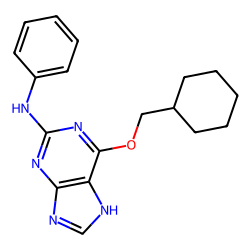

In [2]:
def fetch_ligand_instance_sdf(pdb_id: str, lig_id: str, chain_id: str | None = None):
    """
    Download ligand instance(s) from RCSB ModelServer as SDF with correct bonds/charges.
    Returns a list of RDKit Mol objects (each with a 3D conformer from the crystal).
    """
    base = f"https://models.rcsb.org/v1/{pdb_id}/ligand?label_comp_id={lig_id}&encoding=sdf"
    url = base + (f"&auth_asym_id={chain_id}" if chain_id else "")
    r = requests.get(url)
    r.raise_for_status()

    # RDKit SDF supplier on bytes
    supp = Chem.ForwardSDMolSupplier(io.BytesIO(r.content), removeHs=False, sanitize=True)
    mols = [m for m in supp if m is not None]
    if not mols:
        raise ValueError(f"No ligand molecules returned for {pdb_id}:{lig_id} (chain={chain_id})")

    # Optional: report instance identifiers if present
    for i, m in enumerate(mols):
        name = m.GetProp("_Name") if m.HasProp("_Name") else f"{lig_id}"
        print(f"[INFO] Instance {i}: name={name}, atoms={m.GetNumAtoms()}, confs={m.GetNumConformers()}")
    return mols

def add_hydrogens_preserve_coords(m: Chem.Mol) -> Chem.Mol:
    """
    Adds explicit hydrogens using existing 3D coordinates; heavy atoms are unchanged.
    """
    if m.GetNumConformers() == 0:
        raise ValueError("Ligand has no 3D conformer; cannot place hydrogens with coordinates.")
    mH = Chem.AddHs(m, addCoords=True)
    return mH

def get_smiles_from_rcsb_graphql(ligand_ids):
    """Return a {ligand_id: canonical_SMILES} dict from RCSB GraphQL API."""
    base_url = "https://data.rcsb.org/graphql"
    query_fmt = "[" + ", ".join(['"' + i + '"' for i in ligand_ids]) + "]"
    query = f"""
    {{
      chem_comps(comp_ids:{query_fmt}) {{
        chem_comp {{ id }}
        rcsb_chem_comp_descriptor {{ SMILES_stereo }}
      }}
    }}
    """
    r = requests.post(base_url, json={"query": query})
    r.raise_for_status()
    data = r.json()["data"]["chem_comps"]
    out = {}
    for d in data:
        cid = d["chem_comp"]["id"]
        desc = d.get("rcsb_chem_comp_descriptor")
        if desc and desc.get("SMILES_stereo"):
            out[cid] = desc["SMILES_stereo"]
    return out

# === Parameters ===
pdb_id = "1H1Q"
lig_id = "2A6"
chain_id = "A"  # set to None to pull all instances

# === Fetch co-crystal ligand instance(s) ===
mols = fetch_ligand_instance_sdf(pdb_id, lig_id, chain_id)

# Choose which instance you want (if multiple). Default: first.
ref = mols[0]

# Save the raw (as-modeled) ligand too, if you like
Chem.MolToMolFile(ref, f"{lig_id}_ref_as_modeled.mol")

# === Protonate without moving heavy atoms ===
refH = add_hydrogens_preserve_coords(ref)
Chem.MolToMolFile(refH, f"{lig_id}_ref_protonated.mol")
Chem.MolToPDBFile(refH, f"{lig_id}_ref_protonated.pdb")  # for visual sanity check
print(f"[INFO] Saved {lig_id}_ref_protonated.mol with {refH.GetNumAtoms()} atoms")

# === Fetch canonical SMILES (CCD) ===
smiles_dict = get_smiles_from_rcsb_graphql([lig_id])
if lig_id in smiles_dict:
    co_ligand_smiles = smiles_dict[lig_id]
    print(f"RCSB returned canonical SMILES for {lig_id}:")
    print(co_ligand_smiles)

    # 2D depiction of the CCD ligand (not the crystal pose)
    ref_mol_2d = Chem.MolFromSmiles(co_ligand_smiles)
    if ref_mol_2d:
        img = Draw.MolToImage(ref_mol_2d, size=(250, 250))
        #img.save(f"{lig_id}_ccd_2D.png")
        display(img)
        #print(f"[INFO] Saved 2D depiction to {lig_id}_ccd_2D.png")
else:
    print(f"[WARN] No SMILES_stereo descriptor returned for {lig_id}")


###  **Step 2: Retrieve structurally similar compounds to the co-crystal ligand 2A6, from PubChem**
- I am performing this with a similrity threshold of 85% , and using smiles retrieved in the above step to do this
- limiting the maximum results to 50
- and fetching properties like Molecular Wt, LogP, number of rotatory bonds and TPSA, directly from pubchem

In [3]:
def get_pubchem_similar(smiles, threshold=85, max_results=50):
    """Fetch PubChem compounds similar to input SMILES (Tanimoto >= threshold)."""
    cids = pcp.get_cids(smiles, namespace='smiles', searchtype='similarity',
                        threshold=threshold, listkey_count=max_results)
    comps = pcp.get_compounds(cids[:max_results])
    data = []
    for c in comps:
        data.append({
            "CID": c.cid,
            "SMILES": c.smiles,
            "IUPACName": c.iupac_name,
            "MolWt": c.molecular_weight,
            "LogP": c.xlogp,
            "RotBonds": c.rotatable_bond_count,
            "TPSA": c.tpsa
        })
    return pd.DataFrame(data)

analogs_df = get_pubchem_similar(co_ligand_smiles, threshold=85, max_results=50)
print(f"Retrieved {len(analogs_df)} similar compounds from PubChem.")
analogs_df.head()

Retrieved 50 similar compounds from PubChem.


CID                                             SMILES  \
0     1540        C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=CC=C4   
1     4566  C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=C(C=C4)S...   
2   447649     C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=C(C=C4)O   
3   447655  C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC(=CC=C4)S...   
4  5329555    C1CCC(CC1)COC2=NC(=NC3=C2NC=N3)NC4=CC=CC(=C4)CO   

                                           IUPACName  MolWt  LogP  RotBonds  \
0    6-(cyclohexylmethoxy)-N-phenyl-7H-purin-2-amine  323.4   4.7         5   
1  4-[[6-(cyclohexylmethoxy)-7H-purin-2-yl]amino]...  402.5   3.2         6   
2  4-[[6-(cyclohexylmethoxy)-7H-purin-2-yl]amino]...  339.4   4.3         5   
3  3-[[6-(cyclohexylmethoxy)-7H-purin-2-yl]amino]...  402.5   3.2         6   
4  [3-[[6-(cyclohexylmethoxy)-7H-purin-2-yl]amino...  353.4   3.8         6   

    TPSA  
0   75.7  
1  144.0  
2   96.0  
3  144.0  
4   96.0

### Step 3: Visualize fetched molecules in an RDKit grid
- This step is to simply visualize the fetched molecules and understand the similarity with 2A6 - the co-crystal ligand
- From the molecular grid below it seems most molecules are very similar to the co-crystal molecule.
- We will look at the similarities and differences of the entire dataset, once we also process enamine compounds

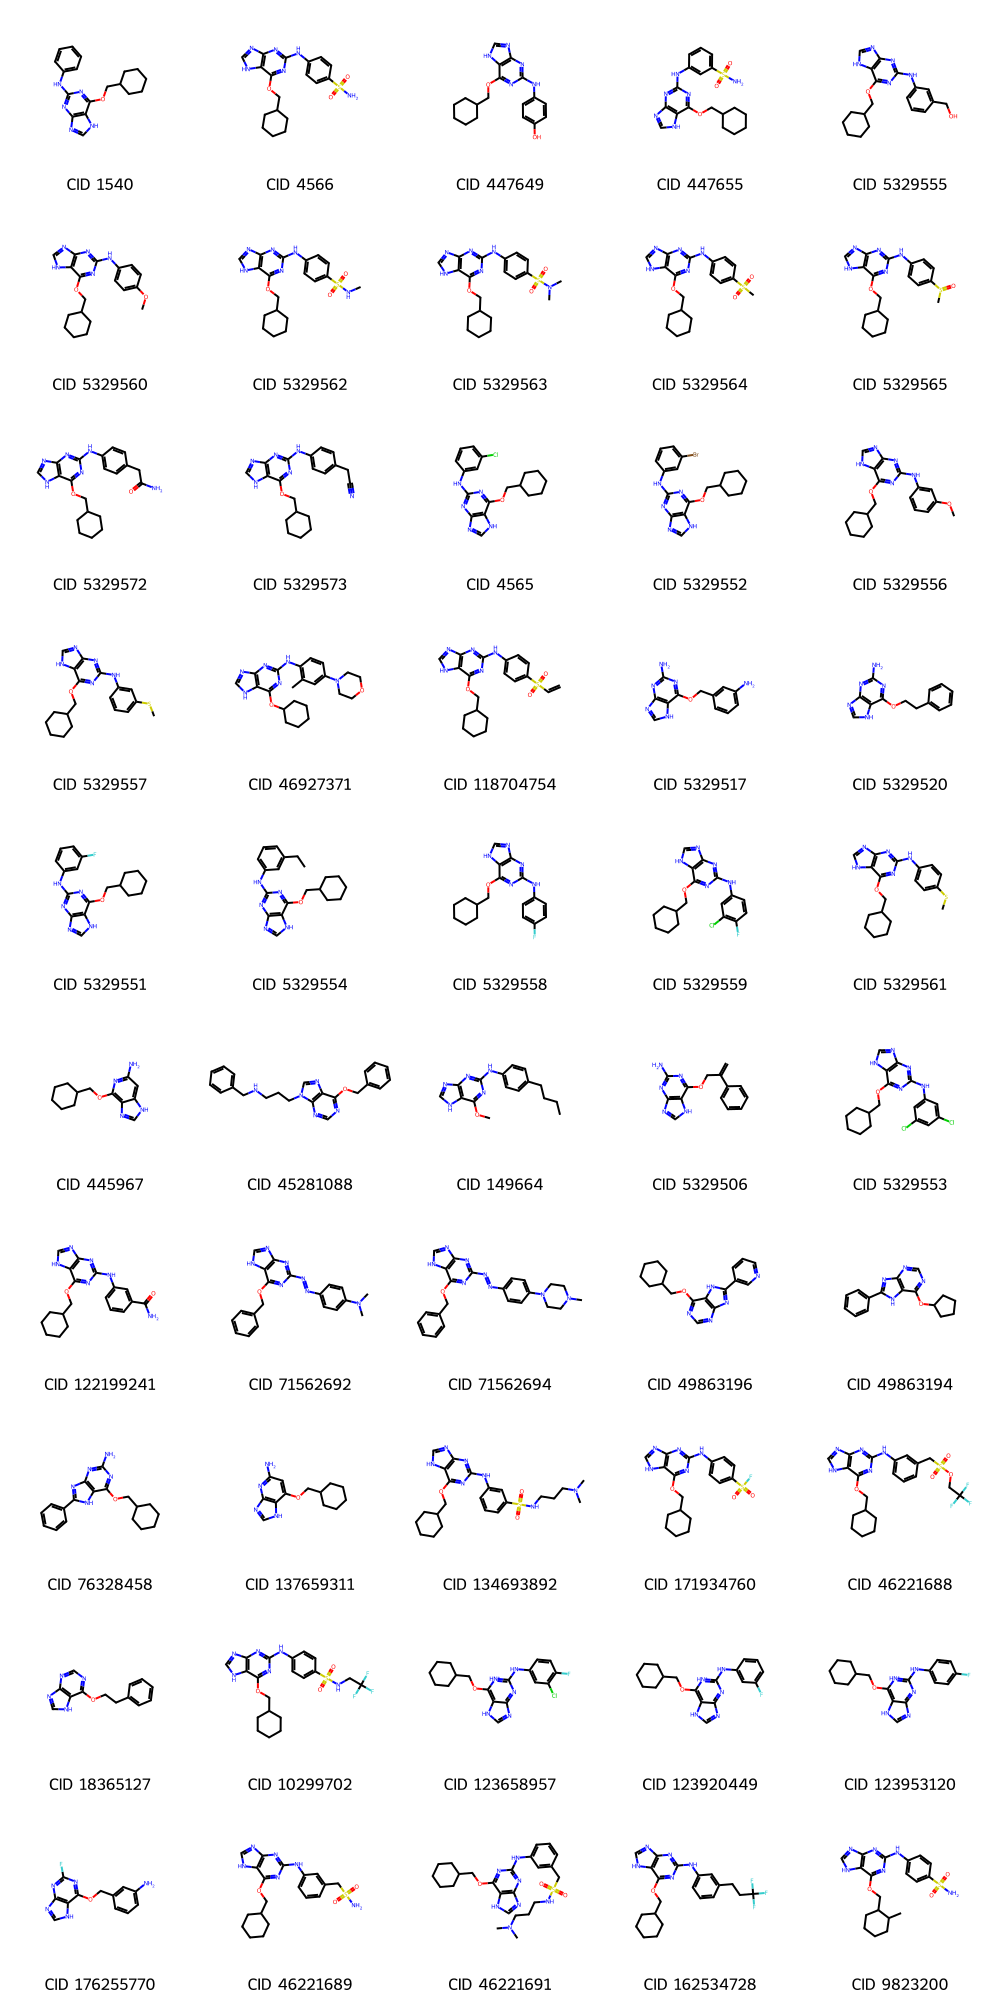

In [4]:
# Creating RDKit Mol objects for visualization
mols = [Chem.MolFromSmiles(smi) for smi in analogs_df["SMILES"]]

# Label each molecule with its PubChem CID
legends = [f"CID {cid}" for cid in analogs_df["CID"]]

# Generate grid image
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=legends,
    useSVG=True
)
img

### **Step 4: Preprocessing and Preparation of the molecules:**
##### **Summary**
- This step ensures all ligands are chemically valid, standardized, and geometrically ready for docking.
- It integrates molecular cleanup, alert and physicochemical filtering, and 3D preparation using Molscrub and Meeko.
- The process yields a clean, protonated, and pH-balanced ligand set suitable for both AutoDock Vina and DiffDock workflows.

------------------------------
#### **Step 4.1: Objectives**
##### **Remove invalid or chemically unstable compounds**
- The function `alert_hits` uses the `CUSTOM_ALERTS` dictionary to remove some of the substructures which should be avoided from a list of hits.
  Some of these include "Carboxylate", "AcidHalide", "AcidAzide" ans so on.
- Filter out undesirable substructures (e.g., Brenk/NIH alerts), with `FilterCatalog` module of `rdkit.Chem`

##### **Apply physicochemical gates** (MW, TPSA, logP, rotatable bonds, halogen count)
- `strict_rotb` and `halogen_count` functions  are first used to calulate the no. of bond rotations in the data, and count the no. of halogens
- We want to restrict the halogen counts in a molecule as some commercial librarues such as Enamine and Mcule, often contain molecules with more than 2 :
  This is obvious a caveat as compounds with -CF3 groups are also filtered in this case, but keeping this for this excercise to show the importance of data cleanup.
##### **Physicochemical Filters**

| Property | Range / Limit |
|-----------|---------------|
| **Molecular Weight (MW)** | 250 – 600 Da |
| **Topological Polar Surface Area (TPSA)** | 40 – 140 Å² |
| **LogP** | <= 5.0 |
| **Rotatable Bonds** | <= 10 |
| **Halogen Count (F, Cl, Br, I)** | <= 2 |

Continued.....

In [5]:
# -- BRENK + NIH + custom filters
CUSTOM_ALERTS = {
    "Carboxylate": "[CX3](=O)[O-]",
    "AcidHalide": "C(=O)[Cl,Br,F,I]",
    "AcidAzide": "C(=O)N=[N+]=[N-]",
    "SulfonylHalide": "S(=O)(=O)[Cl,Br,F,I]",
    "SulfonylAzide": "S(=O)(=O)N=[N+]=[N-]",
    "Catechol": "c1ccc(O)c(O)c1",
    "Isocyanate": "N=C=O",
}
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.NIH)
FILTER = FilterCatalog.FilterCatalog(params)
CUSTOM_PATTS = {n: Chem.MolFromSmarts(s) for n,s in CUSTOM_ALERTS.items()}

def alert_hits(m):
    hits = [e.GetDescription() for e in FILTER.GetMatches(m)]
    for name, patt in CUSTOM_PATTS.items():
        if patt and m.HasSubstructMatch(patt):
            hits.append(name)
    return sorted(set(hits))

def strict_rotb(m): return int(rdMolDescriptors.CalcNumRotatableBonds(m, strict=True))
def halogen_count(m): return sum(a.GetAtomicNum() in (9,17,35,53) for a in m.GetAtoms())
def passes_physchem(m,
                    mw_range=(250,600),
                    tpsa_range=(40,140),
                    logp_max=5.0,
                    rotb_max=10,
                    hal_max=2):
    try:
        mw   = Descriptors.MolWt(m)
        logp = Descriptors.MolLogP(m)
        tpsa = rdMolDescriptors.CalcTPSA(m)
        rotb = int(rdMolDescriptors.CalcNumRotatableBonds(m, strict=True))
        halo = sum(a.GetAtomicNum() in (9,17,35,53) for a in m.GetAtoms())
        ok = (
            mw_range[0] <= mw <= mw_range[1]
            and tpsa_range[0] <= tpsa <= tpsa_range[1]
            and logp < logp_max
            and rotb <= rotb_max
            and halo <= hal_max
        )
        return ok, (mw, logp, tpsa, rotb, halo)
    except Exception:
        # Always return both values, even on failure
        return False, (None, None, None, None, None)

**Continued...**

#### **Step 4.2: Objectives**
##### **Normalize protonation states at physiological pH (7.4)** with `Molscrub`
- The `Molscrub` module standardizes tautomers, removes salts, and assigns protonation states near pH 7.4.  
- While the same can be achieved using a combination of **Meeko + RDKit + OpenBabel**, that approach requires additional handling of special valence cases (e.g., protonated ring nitrogens). To keep this workflow minimal, I used Molscrub as a single-step alternative.  
- **Parallelization** is essential for large libraries (thousands of molecules), since each molecule undergoes geometry generation and protonation correction. Here, CPU-based process pools distribute this workload efficiently across multiple cores.  
- Despite its convenience, **Molscrub is ~2× slower** than the Meeko + RDKit + OpenBabel pipeline, as the latter can be parallelized more efficiently and performs lighter-weight hydrogen and charge adjustments per molecule.



In [6]:
@contextlib.contextmanager
def hush_all():
    from rdkit import RDLogger, rdBase
    RDLogger.DisableLog('rdApp.*')
    with rdBase.BlockLogs():
        with open(os.devnull, "w") as devnull, \
             contextlib.redirect_stdout(devnull), \
             contextlib.redirect_stderr(devnull):
            yield


def _clean_one_pubchem_molscrub(row, mw_range, tpsa_range, logp_max, rotb_max, hal_max, pH, drop_alerts):
    cid = row["CID"]; smi = row["SMILES"]
    if not isinstance(smi, str) or not smi:
        return None

    try:
        # --- Step 1: Parse and clean with molscrub directly ---
        m = Chem.MolFromSmiles(smi)
        if m is None:
            return None

        scrubbed_states = list(scrubber(m))
        if not scrubbed_states:
            return None
        m = scrubbed_states[0]  # take the first low-energy / protonation state
    except Exception:
        return None

    # --- Step 2: Apply alert filters + physicochemical gates ---
    hits = alert_hits(m)
    if drop_alerts and hits:
        return None

    ok, (mw, logp, tpsa, rotb, halo) = passes_physchem(
        m, mw_range, tpsa_range, logp_max, rotb_max, hal_max
    )
    if not ok:
        return None

    smi_out = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
    return {
        "CID": cid,
        "SMILES": smi_out,
        "MolWt": mw,
        "logP": logp,
        "TPSA": tpsa,
        "RotBonds": rotb,
        "HalogenCount": halo,
        "AlertHits": ";".join(hits),
        "AlertAny": bool(hits)
    }

def _process_pubchem_chunk_molscrub(rows, mw_range, tpsa_range, logp_max, rotb_max, hal_max, pH, drop_alerts):
    return [
        _clean_one_pubchem_molscrub(r, mw_range, tpsa_range, logp_max, rotb_max, hal_max, pH, drop_alerts)
        for r in rows
    ]

def clean_pubchem_smiles_parallel_molscrub(analogs_df: pd.DataFrame,
                                           mw_range=(250,600), tpsa_range=(40,140),
                                           logp_max=5.0, rotb_max=10, hal_max=2,
                                           pH=7.4, n_jobs=None, chunksize=256, drop_alerts=False):
    """Parallel cleaning of PubChem molecules using Molscrub Python API."""
    n_jobs = n_jobs or os.cpu_count() or 4
    rows = analogs_df[["CID","SMILES"]].dropna().to_dict("records")
    out = []
    with hush_all():
        with ProcessPoolExecutor(max_workers=n_jobs) as ex:
            futs = []
            for i in range(0, len(rows), chunksize):
                futs.append(ex.submit(_process_pubchem_chunk_molscrub,
                                      rows[i:i+chunksize],
                                      mw_range, tpsa_range, logp_max, rotb_max, hal_max, pH, drop_alerts))
            for f in tqdm(as_completed(futs), total=len(futs), desc="PubChem", unit="chunk"):
                out.extend([r for r in f.result() if r is not None])
    df = pd.DataFrame(out, columns=[
        "CID","SMILES","MolWt","logP","TPSA","RotBonds","HalogenCount","AlertHits","AlertAny"
    ])
    if not df.empty:
        df["Source"] = "PubChem"
    print(f"PubChem kept: {len(df)} / {len(analogs_df)}")
    return df

**Continued...**

#### **Step 4.3: Objectives**
##### **Separate Processing of Enamine and PubChem Molecules**

The Enamine library and PubChem analogs are processed separately because of differences in **input format** and **molecular composition**:

| Dataset | Input Type | Processing Logic | Reason for Separate Handling |
|----------|-------------|------------------|------------------------------|
| **Enamine** | `.sdf` (2D structures, may include salts) | Read using `ForwardSDMolSupplier` → batched as MolBlocks → cleaned with `Molscrub` | Although Enamine compounds are stored as 2D SDFs, they frequently contain salts or counterions. These must be stripped and neutralized before standardization. The batch-based design enables efficient parallel cleanup of thousands of entries. |
| **PubChem** | SMILES (2D strings, no salts in this set) | Parsed as SMILES → protonated and standardized with `Molscrub` | PubChem analogs are supplied as clean SMILES strings without salts or explicit 3D information. Each molecule is independently processed into a normalized, protonated form. |

- **Parallelization** is key for the Enamine set, which can contain tens of thousands of molecules — reading and sanitizing SDF entries is I/O-intensive compared to lightweight SMILES parsing.  
- Both datasets undergo identical **physicochemical filters** (MW, TPSA, logP, rotatable bonds, halogen count) and **structural alert checks** (BRENK / NIH).  
- The goal is to produce a uniform, ready-to-dock library with consistent protonation, tautomer states, and property ranges.


In [7]:
# initialize once (lightweight)
from molscrub import Scrub
scrubber = Scrub(ph_low=7.4, ph_high=7.4)

def _yield_sdf_batches(path, batch_size=500, sanitize=True, removeHs=False):
    """
    Yield batches of valid molecule MolBlocks and CIDs from an SDF file.
    MolBlocks (strings) are lightweight and pickle-safe for multiprocessing.
    """
    from rdkit import Chem
    suppl = Chem.ForwardSDMolSupplier(path, sanitize=False, removeHs=removeHs)
    molblocks, cids = [], []

    for m in suppl:
        if m is None:
            continue

        # Optional light sanitize
        if sanitize:
            try:
                Chem.SanitizeMol(m, catchErrors=True)
            except Exception:
                continue

        # ID extraction
        cid = None
        for key in ["CID", "Catalog ID", "_Name", "ID", "Compound_ID"]:
            if m.HasProp(key):
                cid = m.GetProp(key).strip()
                break
        if cid is None:
            cid = f"UNK_{len(molblocks)+1}"

        molblocks.append(Chem.MolToMolBlock(m))  # <- return as MolBlock string
        cids.append(cid)

        if len(molblocks) >= batch_size:
            yield molblocks, cids
            molblocks, cids = [], []

    if molblocks:
        yield molblocks, cids

def _enamine_worker_batch_molscrub(molblocks, cids,
                                   mw_range, tpsa_range,
                                   logp_max, rotb_max, hal_max,
                                   pH, drop_alerts):
    out = []
    bad = propdrop = phfixed = 0

    for mb, cid in zip(molblocks, cids):
        try:
            m = Chem.MolFromMolBlock(mb, sanitize=False, removeHs=False)
            if m is None:
                bad += 1
                continue

            Chem.SanitizeMol(m, catchErrors=True)

            scrubbed_states = list(scrubber(m))
            if not scrubbed_states:
                bad += 1
                continue
            m = scrubbed_states[0]
            phfixed += 1
        except Exception:
            bad += 1
            continue

        hits = alert_hits(m)
        if drop_alerts and hits:
            propdrop += 1
            continue

        ok, (mw, logp, tpsa, rotb, halo) = passes_physchem(
            m, mw_range, tpsa_range, logp_max, rotb_max, hal_max
        )
        if not ok:
            propdrop += 1
            continue

        smi = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
        out.append((cid, smi, mw, logp, tpsa, rotb, halo, ";".join(hits), bool(hits)))

    return out, bad, propdrop, phfixed
        
def clean_enamine_parallel_molscrub(path,
                                    mw_range=(250,600), tpsa_range=(40,140),
                                    logp_max=5.0, rotb_max=10, hal_max=2,
                                    pH=7.4, batch_size=500, n_jobs=None, drop_alerts=False):
    """
    Fully parallel Enamine cleanup using molscrub.
    Reads SDF in small batches and distributes to multiple processes.
    """
    n_jobs = n_jobs or os.cpu_count() or 4
    results = []
    total_bad = total_propdrop = total_phfixed = 0

    with hush_all():
        with ProcessPoolExecutor(max_workers=n_jobs) as ex:
            futs = []
            for molblocks, cids in _yield_sdf_batches(path, batch_size=batch_size):
                futs.append(ex.submit(_enamine_worker_batch_molscrub,
                                      molblocks, cids,
                                      mw_range, tpsa_range,
                                      logp_max, rotb_max, hal_max,
                                      pH, drop_alerts))

            for fut in tqdm(as_completed(futs), total=len(futs), desc="Enamine", unit="batch"):
                out, bad, propdrop, phfixed = fut.result()
                total_bad      += bad
                total_propdrop += propdrop
                total_phfixed  += phfixed
                results.extend(out)

    df = pd.DataFrame(results, columns=[
        "CID","SMILES","MolWt","logP","TPSA","RotBonds","HalogenCount","AlertHits","AlertAny"
    ])
    if not df.empty and df["CID"].isna().any():
        miss = df["CID"].isna()
        df.loc[miss, "CID"] = [f"ENM_{i}" for i in range(1, miss.sum()+1)]
    if not df.empty:
        df["Source"] = "Enamine"

    print(f"Enamine kept: {len(df)} | invalid: {total_bad} | drops: {total_propdrop} | pH-fixed: {total_phfixed}")
    return df


#### **Processing the Complete Enamine Hinge-Binder Library (~24,000 compounds)**

In this step, the entire Enamine hinge-binder library is preprocessed rather than only a subset.  
The purpose is to **simulate a realistic large-scale screening workflow** where a full vendor library is cleaned, standardized, and prepared for downstream analysis.

- After preprocessing, the goal is to **select the top compounds most similar to the co-crystal ligand**, based on Tanimoto similarity of molecular fingerprints.  
- These top-ranked Enamine compounds will then be **merged with the PubChem analog dataset** to form a unified ligand pool for docking and DiffDock evaluation.  
- This approach demonstrates a typical early-stage **virtual screening pipeline** — starting with a broad chemical space and progressively filtering it down to high-priority candidates for detailed 3D modeling and binding analysis.

The similarity-based selection and comparative property analysis are implemented in the following cells.

In [8]:
pubchem_clean_df = clean_pubchem_smiles_parallel_molscrub(
    analogs_df,
    mw_range=(250,600), tpsa_range=(40,140),
    logp_max=5.0, rotb_max=10, hal_max=2,
    n_jobs=8, chunksize=256, drop_alerts=False
)

enamine_clean_df = clean_enamine_parallel_molscrub(
    "Enamine_Kinase_Hinge_Binders_Library_plated_24000cmpds_20251019.sdf",
    mw_range=(300,600), tpsa_range=(40,140),
    logp_max=5.0, rotb_max=10, hal_max=2,
    n_jobs=8, batch_size=1000, drop_alerts=False
)

PubChem:   0%|          | 0/1 [00:00<?, ?chunk/s]

PubChem kept: 41 / 50


Enamine:   0%|          | 0/24 [00:00<?, ?batch/s]

Enamine kept: 17600 | invalid: 0 | drops: 6400 | pH-fixed: 24000


##### Note :As depicted in the following dataframe, the AlertHits correctly captured the BRENK/NIH and custom structure filter hits, such as "**Carboxylate**, **hydroquinone**, etc

In [9]:
# --- Combine PubChem and Enamine dataframes ---
combined = pd.concat([pubchem_clean_df, enamine_clean_df], ignore_index=True)

# --- Optional deduplication (keeps first occurrence of same SMILES string) ---
combined = combined.dropna(subset=["SMILES"]).drop_duplicates(subset=["SMILES"]).reset_index(drop=True)

print("Sources\n", combined["Source"].value_counts())
print("Rows:", len(combined))
combined.head()

Sources
 Source
Enamine    17600
PubChem       41
Name: count, dtype: int64
Rows: 17641


CID                                             SMILES    MolWt  \
0     1540  [H]c1c([H])c([H])c(N([H])c2nc(OC([H])([H])C3([...  323.400   
1     4566  [H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1...  402.480   
2   447649  [H]Oc1c([H])c([H])c(N([H])c2nc(OC([H])([H])C3(...  339.399   
3   447655  [H]c1c([H])c(N([H])c2nc(OC([H])([H])C3([H])C([...  402.480   
4  5329555  [H]OC([H])([H])c1c([H])c([H])c([H])c(N([H])c2n...  353.426   

     logP    TPSA  RotBonds  HalogenCount     AlertHits  AlertAny   Source  
0  4.0556   75.72         5             0                   False  PubChem  
1  2.7030  135.88         7             0                   False  PubChem  
2  3.7612   95.95         6             0  hydroquinone      True  PubChem  
3  2.7030  135.88         7             0                   False  PubChem  
4  3.5479   95.95         7             0                   False  PubChem

In [10]:
combined_clean = combined[(combined.AlertAny == False)]

In [11]:
combined_clean

CID                                             SMILES  \
0             1540  [H]c1c([H])c([H])c(N([H])c2nc(OC([H])([H])C3([...   
1             4566  [H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1...   
3           447655  [H]c1c([H])c(N([H])c2nc(OC([H])([H])C3([H])C([...   
4          5329555  [H]OC([H])([H])c1c([H])c([H])c([H])c(N([H])c2n...   
5          5329560  [H]c1c([H])c(N([H])c2nc(OC([H])([H])C3([H])C([...   
...            ...                                                ...   
17636   Z298695440  [H]C1=Nc2c(C(=O)N([H])C([H])([H])C([H])(c3c([H...   
17637   Z317758422  [H]C1=C(c2c([H])n([H])c3nc([H])c([H])c([H])c23...   
17638  Z1385479955  [H]c1nc(C([H])([H])[N+]([H])([H])C([H])(c2c([H...   
17639  Z1188818842  [H]c1nc2n(n1)C([H])([H])C([H])(N([H])C(=O)c1c(...   
17640  Z1620664117  [H]c1c([H])c([H])c(N([H])c2c([H])c([H])c(F)c([...   

         MolWt     logP    TPSA  RotBonds  HalogenCount AlertHits  AlertAny  \
0      323.400  4.05560   75.72         5             0               False   
1      402.480  2.70300  135.88         7             0               False   
3      402.480  2.70300  135.88         7             0               False   
4      353.426  3.54790   95.95         7             0               False   
5      353.426  4.06420   84.95         7             0               False   
...        ...      ...     ...       ...           ...       ...       ...   
17636  381.439  4.11290   75.07         5             0               False   
17637  428.492  4.67624   84.25         7             0               False   
17638  345.829  2.76902   47.32         7             2               False   
17639  377.470  1.05180   97.19         8             0               False   
17640  345.349  3.17310   70.23         4             2               False   

        Source  
0      PubChem  
1      PubChem  
3      PubChem  
4      PubChem  
5      PubChem  
...        ...  
17636  Enamine  
17637  Enamine  
17638  Enamine  
17639  Enamine  
17640  Enamine  

[15404 rows x 10 columns]

#### **Similarity Analysis and Filtering Based on Co-crystal Ligand**

In this step, all preprocessed Enamine and PubChem compounds are compared to the **co-crystal ligand** to prioritize structurally similar candidates for docking.  

**Overview of the process:**
- The script first ensures consistent column naming (`SMILES_CAN` / `CID`) and assigns each compound’s source (`Enamine` or `PubChem`).
- A **Morgan fingerprint (ECFP4, radius=2, 2048 bits)** is generated for each molecule, and **Tanimoto similarity** is calculated against the co-crystal ligand.
- Molecules that are *too similar* to the co-ligand (`Sim_to_CoLig > 0.99`) are dropped to avoid duplicates, while compounds with similarity above **0.80** are considered *close analogs*.
- Distributions of similarity values and rotatable bond counts are visualized using histograms and ECDF plots to assess diversity between the two datasets.

This step allows identification of **top structural neighbors** from the Enamine and PubChem sets, enabling a focused subset for downstream docking and DiffDock screening.

##### **Similarity and Property Distributions**

The following plots compare the processed **Enamine** and **PubChem** datasets with respect to their similarity to the co-crystal ligand and molecular flexibility characteristics:

1. **Tanimoto Similarity Histogram**  
   - Displays the distribution of ECFP4 (Morgan fingerprint) similarities between each compound and the co-crystal ligand.  
   - The **dashed line at 0.80** marks the “close analog” threshold.  
   - Most Enamine compounds are structurally diverse (low similarity), while PubChem analogs cluster closer to the co-ligand.

2. **Empirical Cumulative Distribution Function (ECDF)**  
   - Shows the cumulative fraction of molecules with similarity ≤ a given value.  
   - A steeper ECDF curve means the dataset contains many molecules clustered within a narrow similarity range.  
   - Enamine’s ECDF rises sharply at low similarity values, indicating a broad, diverse library. PubChem’s curve increases gradually, showing more focused similarity to the co-ligand.  
   - **Definition:**  
     \[
     ECDF(x) = \frac{\text{Number of samples } \leq x}{\text{Total number of samples}}
     \]

3. **Rotatable Bonds Distribution**  
   - Compares molecular flexibility (number of strict rotatable bonds) across both datasets.  
   - Both libraries mainly contain molecules with fewer than **10 rotatable bonds**, aligning with the physicochemical filter applied earlier.


In [12]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

SMI_COL = "SMILES_CAN" if "SMILES_CAN" in combined_clean.columns else "SMILES"
ID_COL  = "LIG_ID" if "LIG_ID" in combined_clean.columns else "CID"

# If Source missing, infer (adjust as needed for your IDs)
if "Source" not in combined_clean.columns:
    combined_clean = combined_clean.copy()
    combined_clean["Source"] = np.where(
        combined_clean[ID_COL].astype(str).str.startswith(("ENM_","ENAM")),
        "Enamine", "PubChem"
    )

# ========= Build co-ligand fingerprint =========
co_mol = Chem.MolFromSmiles(co_ligand_smiles)
assert co_mol is not None, "co_ligand_smiles failed to parse."
co_fp = morgan_gen.GetFingerprint(co_mol)

# ========= Helpers =========
def mfp4(smi: str):
    m = Chem.MolFromSmiles(smi)
    return morgan_gen.GetFingerprint(m) if m else None

def rot_bonds_strict(smi: str):
    m = Chem.MolFromSmiles(smi)
    return int(rdMolDescriptors.CalcNumRotatableBonds(m, strict=True)) if m else np.nan

# ========= Compute FPS/props if missing =========
df = combined_clean.copy()

if "FP" not in df.columns:
    df["FP"] = df[SMI_COL].map(mfp4)
df = df.dropna(subset=["FP"]).reset_index(drop=True)

if "RotBonds" not in df.columns or df["RotBonds"].isna().any():
    df["RotBonds"] = df[SMI_COL].map(rot_bonds_strict)

# ========= Similarity to co-ligand =========
fps = list(df["FP"])
df["Sim_to_CoLig"] = BulkTanimotoSimilarity(co_fp, fps)

# ========= Optional: Drop near-duplicates to co-ligand =========
DROP_NEAR_DUP = True
SIM_DROP_THR = 0.99
if DROP_NEAR_DUP:
    before = len(df)
    df = df[df["Sim_to_CoLig"] <= SIM_DROP_THR].reset_index(drop=True)
    print(f"Removed {before - len(df)} ligands with similarity > {SIM_DROP_THR:.2f} to the co-ligand.")

# ========= Summary =========
CLOSE_THR = 0.80
summary = (
    df.assign(Close=df["Sim_to_CoLig"] >= CLOSE_THR)
      .groupby(["Source","Close"])[ID_COL]
      .count()
      .unstack(fill_value=0)
      .rename(columns={False:"< threshold", True:">= threshold"})
)
print(f"\nCounts per source with Sim_to_CoLig >= {CLOSE_THR:.2f}:")
summary


Removed 1 ligands with similarity > 0.99 to the co-ligand.

Counts per source with Sim_to_CoLig >= 0.80:


Close    < threshold  >= threshold
Source                            
Enamine        15369             0
PubChem           33             1

##### **Similarity and Property Distributions**

The following plots compare the processed **Enamine** and **PubChem** datasets with respect to their similarity to the co-crystal ligand and molecular flexibility characteristics:

1. **Tanimoto Similarity Histogram**  
   - Displays the distribution of ECFP4 (Morgan fingerprint) similarities between each compound and the co-crystal ligand.  
   - The **dashed line at 0.80** marks the **“close analog”** threshold.  
   - **Most Enamine compounds are structurally diverse (low similarity)**, while PubChem analogs cluster closer to the co-ligand.

2. **Empirical Cumulative Distribution Function (ECDF)**  
   - Shows the cumulative fraction of molecules with similarity ≤ a given value.  
   - A steeper ECDF curve means the dataset contains many molecules clustered within a narrow similarity range.  
   - Enamine’s ECDF rises sharply at low similarity values, indicating a broad, diverse library. PubChem’s curve increases gradually, showing more focused similarity to the co-ligand.  
   - **Definition:**  
        $$
        ECDF(x) = \frac{\text{Number of samples } \leq x}{\text{Total number of samples}}
        $$
3. **Rotatable Bonds Distribution**  
   - Compares molecular flexibility (number of strict rotatable bonds) across both datasets.  
   - Both libraries mainly contain molecules with fewer than or equal to **10 rotatable bonds**, aligning with the physicochemical filter applied earlier.

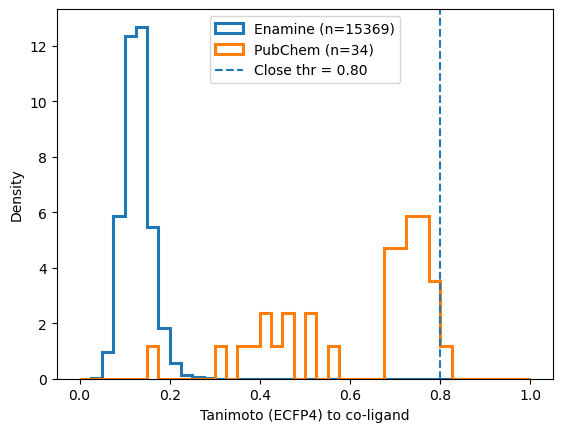

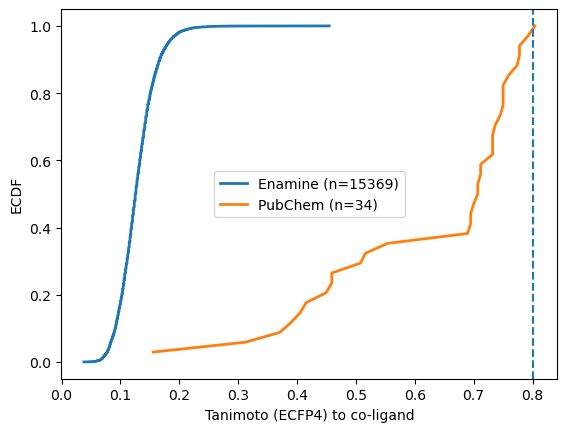

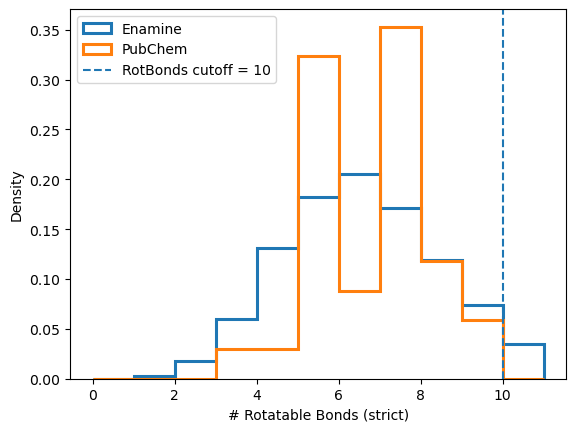

In [13]:
# ========= Plots =========
df_plot = df.copy()
pc = df_plot.loc[df_plot["Source"]=="PubChem","Sim_to_CoLig"].dropna()
en = df_plot.loc[df_plot["Source"]=="Enamine","Sim_to_CoLig"].dropna()

bins = np.linspace(0, 1, 41)  # common bins

# 1) Similarity histogram
fig, ax = plt.subplots()
if len(en): ax.hist(en, bins=bins, histtype="step", density=True, linewidth=2.2, label=f"Enamine (n={len(en)})")
if len(pc): ax.hist(pc, bins=bins, histtype="step", density=True, linewidth=2.2, label=f"PubChem (n={len(pc)})")
ax.axvline(CLOSE_THR, ls="--", lw=1.5, label=f"Close thr = {CLOSE_THR:.2f}")
ax.set_xlabel("Tanimoto (ECFP4) to co-ligand"); ax.set_ylabel("Density")
ax.legend(); plt.show()

# 2) ECDF
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

fig, ax = plt.subplots()
if len(en):
    xe, ye = ecdf(en.values)
    ax.plot(xe, ye, lw=2, label=f"Enamine (n={len(en)})")
if len(pc):
    xp, yp = ecdf(pc.values)
    ax.plot(xp, yp, lw=2, label=f"PubChem (n={len(pc)})")
ax.axvline(CLOSE_THR, ls="--", lw=1.5)
ax.set_xlabel("Tanimoto (ECFP4) to co-ligand"); ax.set_ylabel("ECDF")
ax.legend(); plt.show()

# 3) Rotatable-bonds histogram
pc_rb = df_plot.loc[df_plot["Source"]=="PubChem","RotBonds"].dropna()
en_rb = df_plot.loc[df_plot["Source"]=="Enamine","RotBonds"].dropna()
rb_bins = np.arange(0, int(df_plot["RotBonds"].max())+2)

fig, ax = plt.subplots()
if len(en_rb): ax.hist(en_rb, bins=rb_bins, histtype="step", density=True, linewidth=2.2, label="Enamine")
if len(pc_rb): ax.hist(pc_rb, bins=rb_bins, histtype="step", density=True, linewidth=2.2, label="PubChem")
ax.axvline(10, ls="--", lw=1.5, label="RotBonds cutoff = 10")
ax.set_xlabel("# Rotatable Bonds (strict)"); ax.set_ylabel("Density")
ax.legend(); plt.show()

# (optional) Keep this df for downstream docking selection:
filtered_df = df.copy()

##### **Note:** 
- There is a single molecule from the PubChem analog set which is at 0.8 similarity threshold :  `CID: 5329558`
- This analog is the Fluoro analog of the co-cyrtsal ligand
- The PubChem molecules are actually very similar (max 0.8 and min 0.39 Tanimoto similairty with ECFP4 fingerprints
- The **Enamine Hinge Binding Dataset has only 5 molecules larger than 0.4 Tanimoto similairty** : meaning **this dataset is structurally different than the co-crystal ligand**:
  -- 'Z2611810317', 'Z2613622720', 'Z2792840666', 'Z2610310359', 'Z2611593143' are the molecules with > 0.3 Tanimoto similarity to the co-crystal ligand

In [14]:
CLOSE_THR    = 0.80
SIM_DROP_THR = 0.99   

df_before_drop = df.copy()
n_close_before = (df_before_drop["Sim_to_CoLig"] >= CLOSE_THR).sum()
n_dropped      = (df_before_drop["Sim_to_CoLig"] >  SIM_DROP_THR).sum()
print(f"Close (≥ {CLOSE_THR:.2f}) BEFORE drop: {n_close_before}")
print(f"Dropped (> {SIM_DROP_THR:.2f}) BEFORE drop: {n_dropped}")

# Only build df_after_drop if you want to filter:
df_after_drop  = df_before_drop[df_before_drop["Sim_to_CoLig"] <= SIM_DROP_THR].reset_index(drop=True)


Close (≥ 0.80) BEFORE drop: 1
Dropped (> 0.99) BEFORE drop: 0


In [15]:
list(df_before_drop[(df_before_drop.Source == 'Enamine') & (df_before_drop.Sim_to_CoLig >= 0.3)].CID)

['Z2611810317', 'Z2613622720', 'Z2792840666', 'Z2610310359', 'Z2611593143']

In [16]:
TOPN = 200  # insepecting 60 moelcules as 44 of these are from similarity selections from PubChem
df_top = df_before_drop.sort_values("Sim_to_CoLig", ascending=False).head(TOPN)
#print(df_top[[ID_COL, "Source", "Sim_to_CoLig"]].to_string(index=False))

# Visualize them in a grid with exact similarity labels
mols = [Chem.MolFromSmiles(s) for s in df_top[SMI_COL]]
legends = [f"{r[ID_COL]} | {r['Sim_to_CoLig']:.3f}" for _, r in df_top.iterrows()]
img = Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(220,220), legends=legends, useSVG=True, maxMols=200)
display(img)


In [17]:
# --- base dataframe ---
df_base = df_top.copy()

# --- key columns ---
SMI_COL = "SMILES_CAN" if "SMILES_CAN" in df_base.columns else "SMILES"
ID_COL  = "LIG_ID" if "LIG_ID" in df_base.columns else "CID"

# --- helper functions ---
def canonicalize_smiles(smi: str):
    """Return canonical, isomeric SMILES from input string."""
    try:
        m = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True) if m else None
    except Exception:
        return None

scrubber = Scrub(ph_low=7.4, ph_high=7.4)

def prep_with_scrub(smi, lig_id="Lig"):
    """Return cleaned, protonated RDKit Mol (3D) from SMILES via Molscrub."""
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        return None
    try:
        states = list(scrubber(mol))
        if not states:
            return None
        m = states[0]
        Chem.SanitizeMol(m, catchErrors=True)
        m.SetProp("_Name", lig_id)
        return m
    except Exception as e:
        print(f"[WARN] Molscrub failed for {lig_id}: {e}")
        return None

# --- Build co-ligand row ---
co_can = canonicalize_smiles(co_ligand_smiles)
if not co_can:
    raise ValueError("co_ligand_smiles failed to parse.")

co_mol = prep_with_scrub(co_can, "COLIG_2A6")
if co_mol is None:
    raise ValueError("Molscrub failed to prepare co-ligand.")

# molecular descriptors
mw        = Descriptors.MolWt(co_mol)
logp      = Crippen.MolLogP(co_mol)
tpsa      = rdMolDescriptors.CalcTPSA(co_mol)
rotb      = int(rdMolDescriptors.CalcNumRotatableBonds(co_mol, strict=True))
halogens  = sum(a.GetAtomicNum() in (9,17,35,53) for a in co_mol.GetAtoms())
alerts    = alert_hits(co_mol)

co_row = {
    ID_COL: "COLIG_2A6",
    SMI_COL: co_can,
    "SMILES_CAN": co_can,
    "Source": "CoLigand",
    "IsCoLigand": True,
    "Sim_to_CoLig": 1.0,
    "MolWt": mw,
    "logP": logp,
    "TPSA": tpsa,
    "RotBonds": rotb,
    "HalogenCount": halogens,
    "AlertHits": ";".join(sorted(set(alerts))),
    "AlertAny": bool(alerts),
    "SMILES": co_ligand_smiles,
}

# --- Merge with top-200 ligands ---
# ensure SMILES_CAN exists for deduplication
if "SMILES_CAN" not in df_base.columns:
    df_base["SMILES_CAN"] = df_base[SMI_COL].map(canonicalize_smiles)

df_with_co = pd.concat([pd.DataFrame([co_row]), df_base], ignore_index=True)
df_with_co = df_with_co.drop_duplicates(subset=["SMILES_CAN"], keep="first").reset_index(drop=True)

print(f"Added co-ligand. Final size: {len(df_with_co)}")

Added co-ligand. Final size: 201


In [18]:
df_with_co['Mols'] = [Chem.MolFromSmiles(smic) for smic in df_with_co.SMILES_CAN]
df_with_co.drop(columns=['IsCoLigand','AlertHits', 'AlertAny'], inplace=True)
PandasTools.WriteSDF(df_with_co, 'cdk2_ligands_top200.sdf', molColName='Mols', idName='CID', properties=df_with_co.columns)

In [19]:
try:
    from meeko import PDBQTWriterLegacy as PDBQTWriter
except ImportError:
    from meeko import PDBQTWriter
import os, pandas as pd

def write_pdbqt_from_df(df, mol_col="Mols", id_col="CID",
                        outdir="pdbqt_ready", charge_model="gasteiger"):
    """
    Convert protonated, 3D RDKit Mol objects to PDBQT via Meeko.
    Handles both legacy and new Meeko return types.
    """
    os.makedirs(outdir, exist_ok=True)
    prep = MoleculePreparation(charge_model=charge_model)
    writer = PDBQTWriter()

    n_ok = n_fail = 0
    rows = []

    for _, row in df.iterrows():
        lig_id = str(row.get(id_col, "Lig"))
        m = row.get(mol_col, None)
        if not isinstance(m, Chem.Mol):
            rows.append({"name": lig_id, "status": "fail", "pdbqt": "", "error": "No Mol object"})
            n_fail += 1
            continue

        try:
            # Ensure explicit Hs
            if not any(a.GetAtomicNum() == 1 for a in m.GetAtoms()):
                m = Chem.AddHs(m, addCoords=True)

            # Ensure conformer
            if m.GetNumConformers() == 0:
                params = AllChem.ETKDGv3()
                params.useRandomCoords = True
                cid = AllChem.EmbedMolecule(m, params)
                if cid != 0:
                    raise RuntimeError("3D embedding failed")
                AllChem.MMFFOptimizeMolecule(m, maxIters=200)

            # Meeko preparation (returns MoleculeSetup or list thereof)
            setup = prep.prepare(m)
            setup_list = setup if isinstance(setup, (list, tuple)) else [setup]

            # Write one or more PDBQTs
            for i, ms in enumerate(setup_list):
                pdbqt_file = os.path.join(outdir, f"{lig_id}.pdbqt" if i == 0 else f"{lig_id}__alt{i+1}.pdbqt")
                pdbqt_str = writer.write_string(ms)
                if isinstance(pdbqt_str, tuple):
                    pdbqt_str = pdbqt_str[0]
                with open(pdbqt_file, "w") as fh:
                    fh.write(pdbqt_str)
            n_ok += 1
            rows.append({"name": lig_id, "status": "ok", "pdbqt": pdbqt_file, "error": ""})

        except Exception as e:
            n_fail += 1
            rows.append({"name": lig_id, "status": "fail", "pdbqt": "", "error": str(e)})
            print(f"[fail] {lig_id}: {e}")

    manifest = pd.DataFrame(rows)
    manifest.to_csv(os.path.join(outdir, "_manifest.csv"), index=False)
    print(f"[done] Meeko write: OK {n_ok} | Fail {n_fail} → {outdir}")
    return manifest


In [20]:
manifest = write_pdbqt_from_df(df_with_co, mol_col="Mols", id_col="CID", outdir="pdbqt_scrubbed")

[done] Meeko write: OK 201 | Fail 0 → pdbqt_scrubbed
